# Assignment Module 7 Logistic Regression

### Group Members:
- Julian Ruggiero
- Omar M. Hussein
- Eli weiss

## Introduction

A bank loan is a personal loan that's issued by either a local or national bank. There are many factor that lead to an individual’sloan being accepted or not. In this assignment we are going to create a series of binary logistic regression models that predict whether or not a given mortgage application is likely to be denied which will help us further understand to what degree each feature affects the likelihood of the loan being accepted by the bank. After constructing and evaluating the logistic regression models, we will identify our preferred model and apply it to a testing subset to assess its performance.

## Data Profiling

The data set is sourced from the Federal Reserve Bank of Boston. A brief overview of the content of the data set can be found here: <br>
https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Hdma.html

The data set is comprised of 2,381 observations of 1 response/dependent variable (which indicates whether or not a mortgage application was denied) and 12 explanatory/independent variables.

- __dir:__ debt payments to total income ratio
- __hir:__ housing expenses to income ratio
- __lvr:__ ratio of size of loan to assessed value of property
- __ccs:__ consumer credit score from 1 to 6 (a low value being a good score)
- __mcs:__ mortgage credit score from 1 to 4 (a low value being a good score)
- __pbcr:__ public bad credit record ?
- __dmi:__ denied mortgage insurance ?
- __self:__ self employed ?
- __single:__ is the applicant single ?
- __uria:__ 1989 Massachusetts unemployment rate in the applicant's industry
- __condominium:__ is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package)
- __black:__ is the applicant black ?
- __deny (response):__ mortgage application denied ?

Below we create a meaningful list of column names and separate the numeric and categorical features.

In [1]:
#create a list of meaningful column names
columns=['debt_pymt_income_ratio', 'house_expen_income_ratio', 'loan_size_prop_value_ratio', 'cons_cred_score',
         'mort_cred_score', 'bad_credit_record','denied_mort_insur','self_emp', 'single', 'unemp_rate_app_industry',
         'unit_condo','black','deny']

# split categorical and numeric features
categorical = ['bad_credit_record', 'denied_mort_insur', 'self_emp', 'single', 'unit_condo', 'black', 'cons_cred_score']

numeric = ['debt_pymt_income_ratio', 'house_expen_income_ratio', 
           'loan_size_prop_value_ratio','mort_cred_score', 
           'unemp_rate_app_industry']

# Exploratory Data Analysis

### Logistic Regression Assumptions
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds.
- Logistic regression requires quite large sample sizes.

Keeping the above assumptions in mind, let’s look at our dataset.

First we will read the data into python using pandas read csv function. We will replace the column names to the ones we define to be more meaningful for analysis purposes. Then we will look for missing and/or invalid data values and perform an exploratory data analysis on our dataset to determine what data need to be prepared for a future machine learning model.

In [2]:
# importing libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from pandas.plotting import scatter_matrix
import missingno as msno
from IPython.display import Markdown, display
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

#loading the data from github repo
df = pd.read_csv("https://raw.githubusercontent.com/OMS1996/DAV-6150-Data-Science/master/Data/M7_Data.csv")

#sanity check
df.head()

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [3]:
#exclude first column and rename the rest
df = df.iloc[:,1:]
df.columns = columns

#sanity check
df.head(2)

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no


Here we will look at the data types and check those records with null values.

In [4]:
#checking df info, including column data types, and if any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   debt_pymt_income_ratio      2381 non-null   float64
 1   house_expen_income_ratio    2381 non-null   float64
 2   loan_size_prop_value_ratio  2381 non-null   float64
 3   cons_cred_score             2381 non-null   float64
 4   mort_cred_score             2381 non-null   float64
 5   bad_credit_record           2380 non-null   object 
 6   denied_mort_insur           2381 non-null   object 
 7   self_emp                    2380 non-null   object 
 8   single                      2381 non-null   object 
 9   unemp_rate_app_industry     2381 non-null   float64
 10  unit_condo                  2381 non-null   int64  
 11  black                       2381 non-null   object 
 12  deny                        2381 non-null   object 
dtypes: float64(6), int64(1), object(6

We can see that there is only 1 record with missing values for 'bad_credit_record' and 1 record for 'self_emp', we will check to see that record/s. Here we also see that the number of observations is large enough to perform logistic regression.

In [5]:
#checking records with null values
df[df.isnull().any(axis=1)]

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,no,NaN,yes,3.774496,0,no,no


Its only one record, among over 2381 observations, hence we can safely exclude it from our analysis. We will do that in the data preparation section.

Now we will perform an exploration of the response distribution, getting the value_counts to see its distribution and then each explanatory variable association with the response. 

no     2096
yes     285
Name: deny, dtype: int64
percentage of no mortage deny is 88.03023939521209
percentage of deny 11.969760604787904


Text(0.5, 1.0, "Mortgage application's denied distribution")

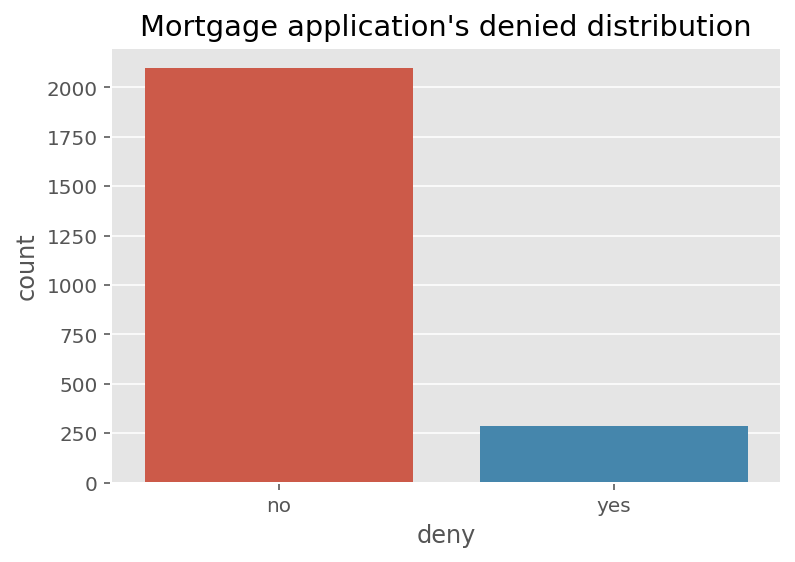

In [6]:
#print value counts
print(df.deny.value_counts())

#get separate counts for each response value to see %
count_no_denied = len(df[df['deny']=='no'])
count_denied = len(df[df['deny']=='yes'])

pct_of_no_deny = count_no_denied/(count_no_denied+count_denied)
print("percentage of no mortage deny is", pct_of_no_deny*100)
pct_of_deny = count_denied/(count_no_denied+count_denied)
print("percentage of deny", pct_of_deny*100)
sns.countplot(x = 'deny', data = df).set_title("Mortgage application's denied distribution")

Our classes are imbalanced, and the ratio of no-denied to denied mortgage application to instances is 88:12. By simply predicting "do not deny" for each applicant we could achieve a training model accuracy of 88%. This metric is referred to as the null error rate. Before we go ahead to balance the classes, let’s do some more exploration.

### EDA on Numeric Features

In [7]:
df.groupby('deny').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo
deny,,,,,,,
no,0.322933,0.250605,0.727070,1.955208,1.699294,3.741925,0.281489
yes,0.388771,0.290212,0.816379,3.301754,1.880702,4.014035,0.336842


We can see that on average, people that get their mortgage application denied have higher:
- debt payments to total income ratio, suggesting that if their income is higher than the debts then this ratio is smaller, and then more likely to get an approved application. 
- housing expenses to income ratio, makes sense, same logic as above.
- ratio of size of loan to assessed value of property, suggesting that more money the applicant requests in comparison to the property value, then the bigger will be this ratio, hence the more likely to be denied.
- consumer credit score, even though this is categorical, it makes sense since a low score is better according to the data dictionary.
- mortgage credit score, makes sense, same logic as above.

Now we will look at the correlations between numeric explanatory variables to detect initial collinearity.

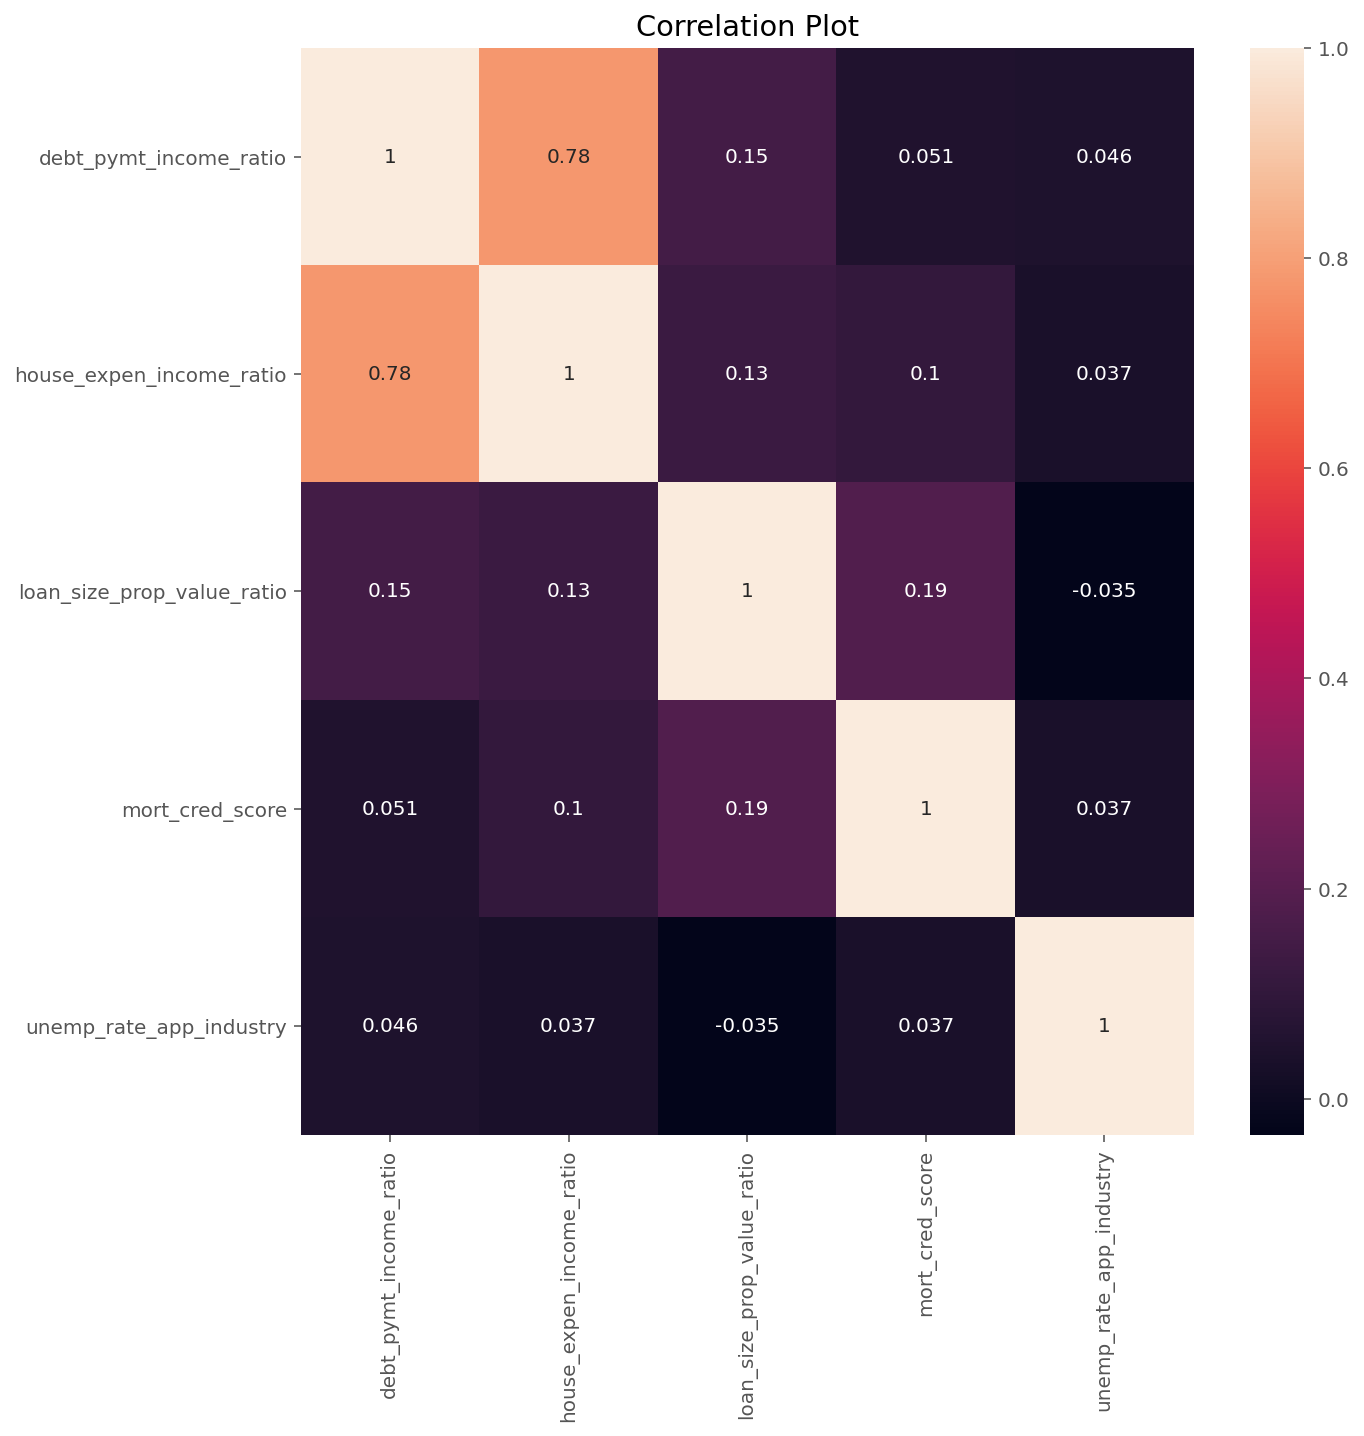

In [8]:
# initial correlation
cor = df[numeric].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

We can see that 'debt_pymt_income_ratio' and 'house_expen_income_ratio' show a correlation of 0.78 suggesting that there might be some collinearity between both variables. Hence, we can keep only one in our analysis.

Looking at the features distributions below we can see the values that each one has and to assess for potential outliers.

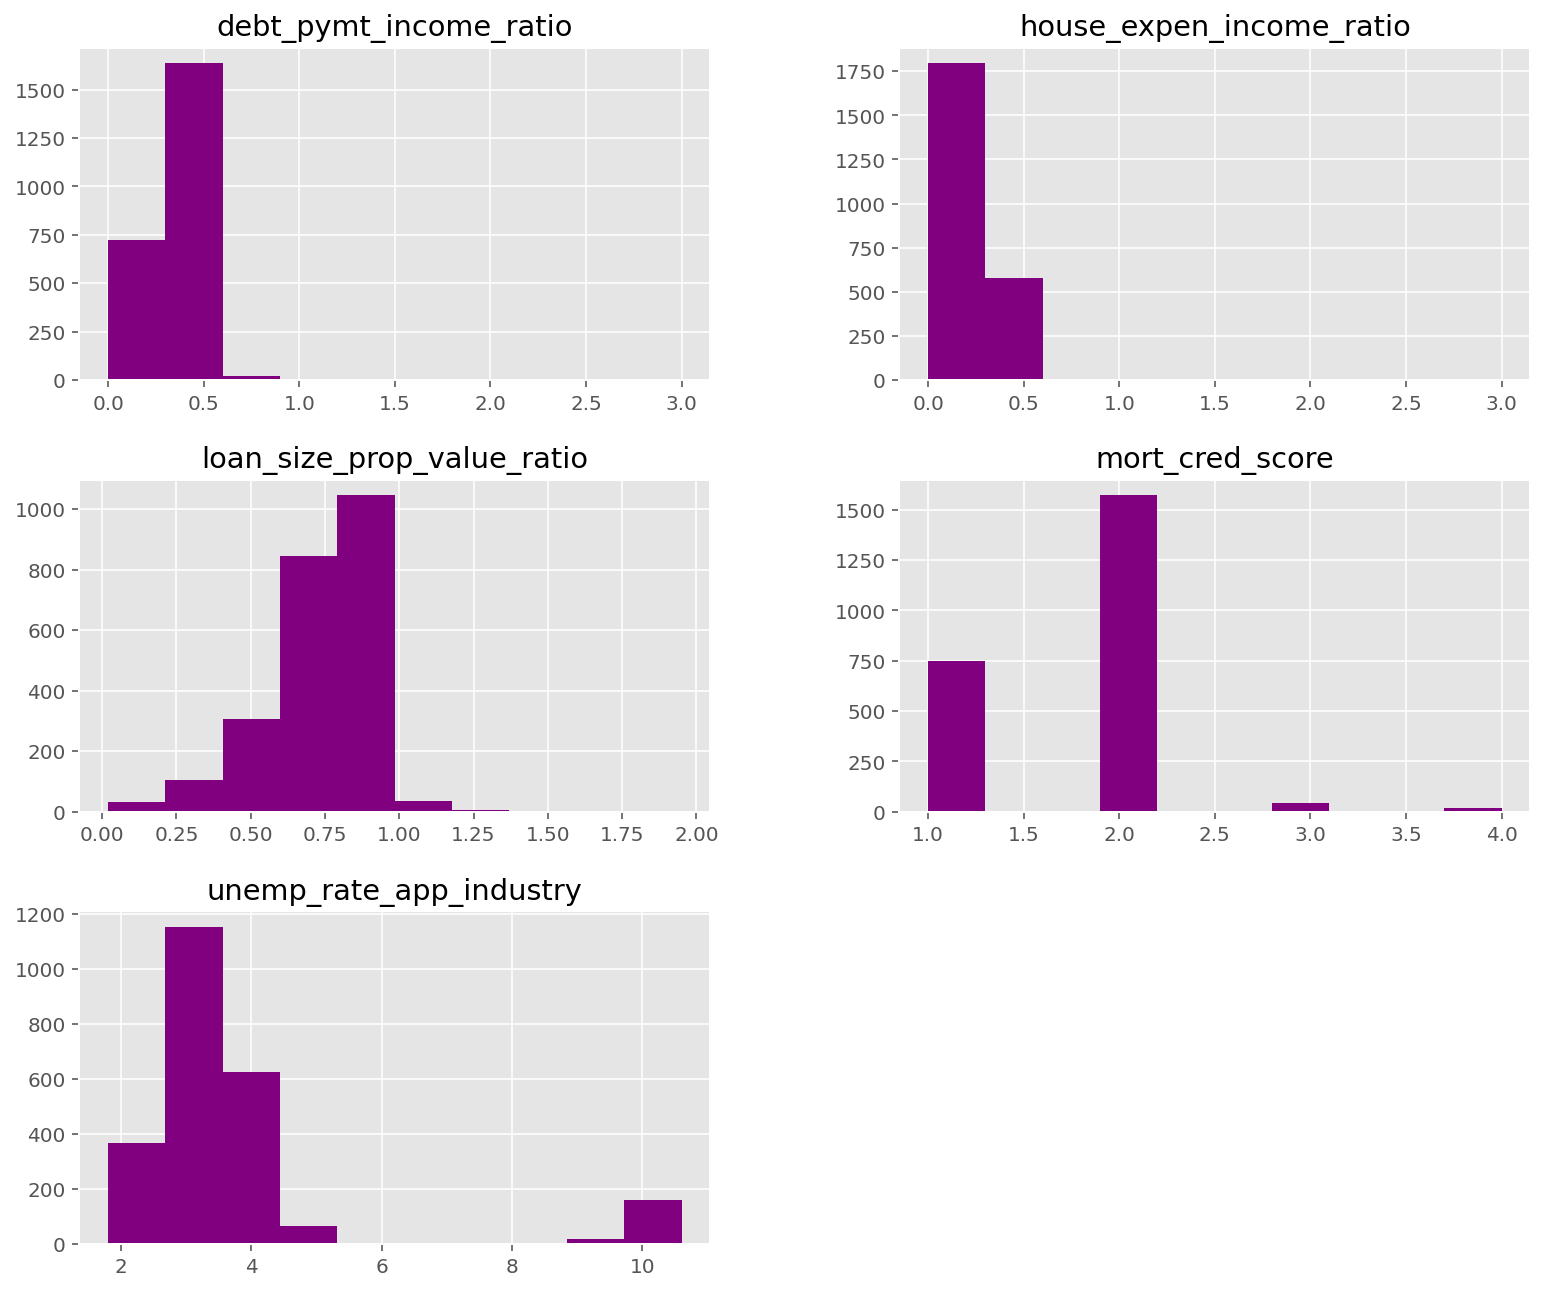

In [9]:
df[numeric].hist(figsize=(13, 11), color='purple');
plt.show();

Below we show each of the numeric variables and the association with the response. Part of the code below was extracted from Project 1 created by Sara, Rachel and Michael. <br>
https://yu.instructure.com/courses/42423/files/1389305/download?wrap=1

We added the response in the horizontal axis (x="deny") to allow a comparison and extract potential predictive features.

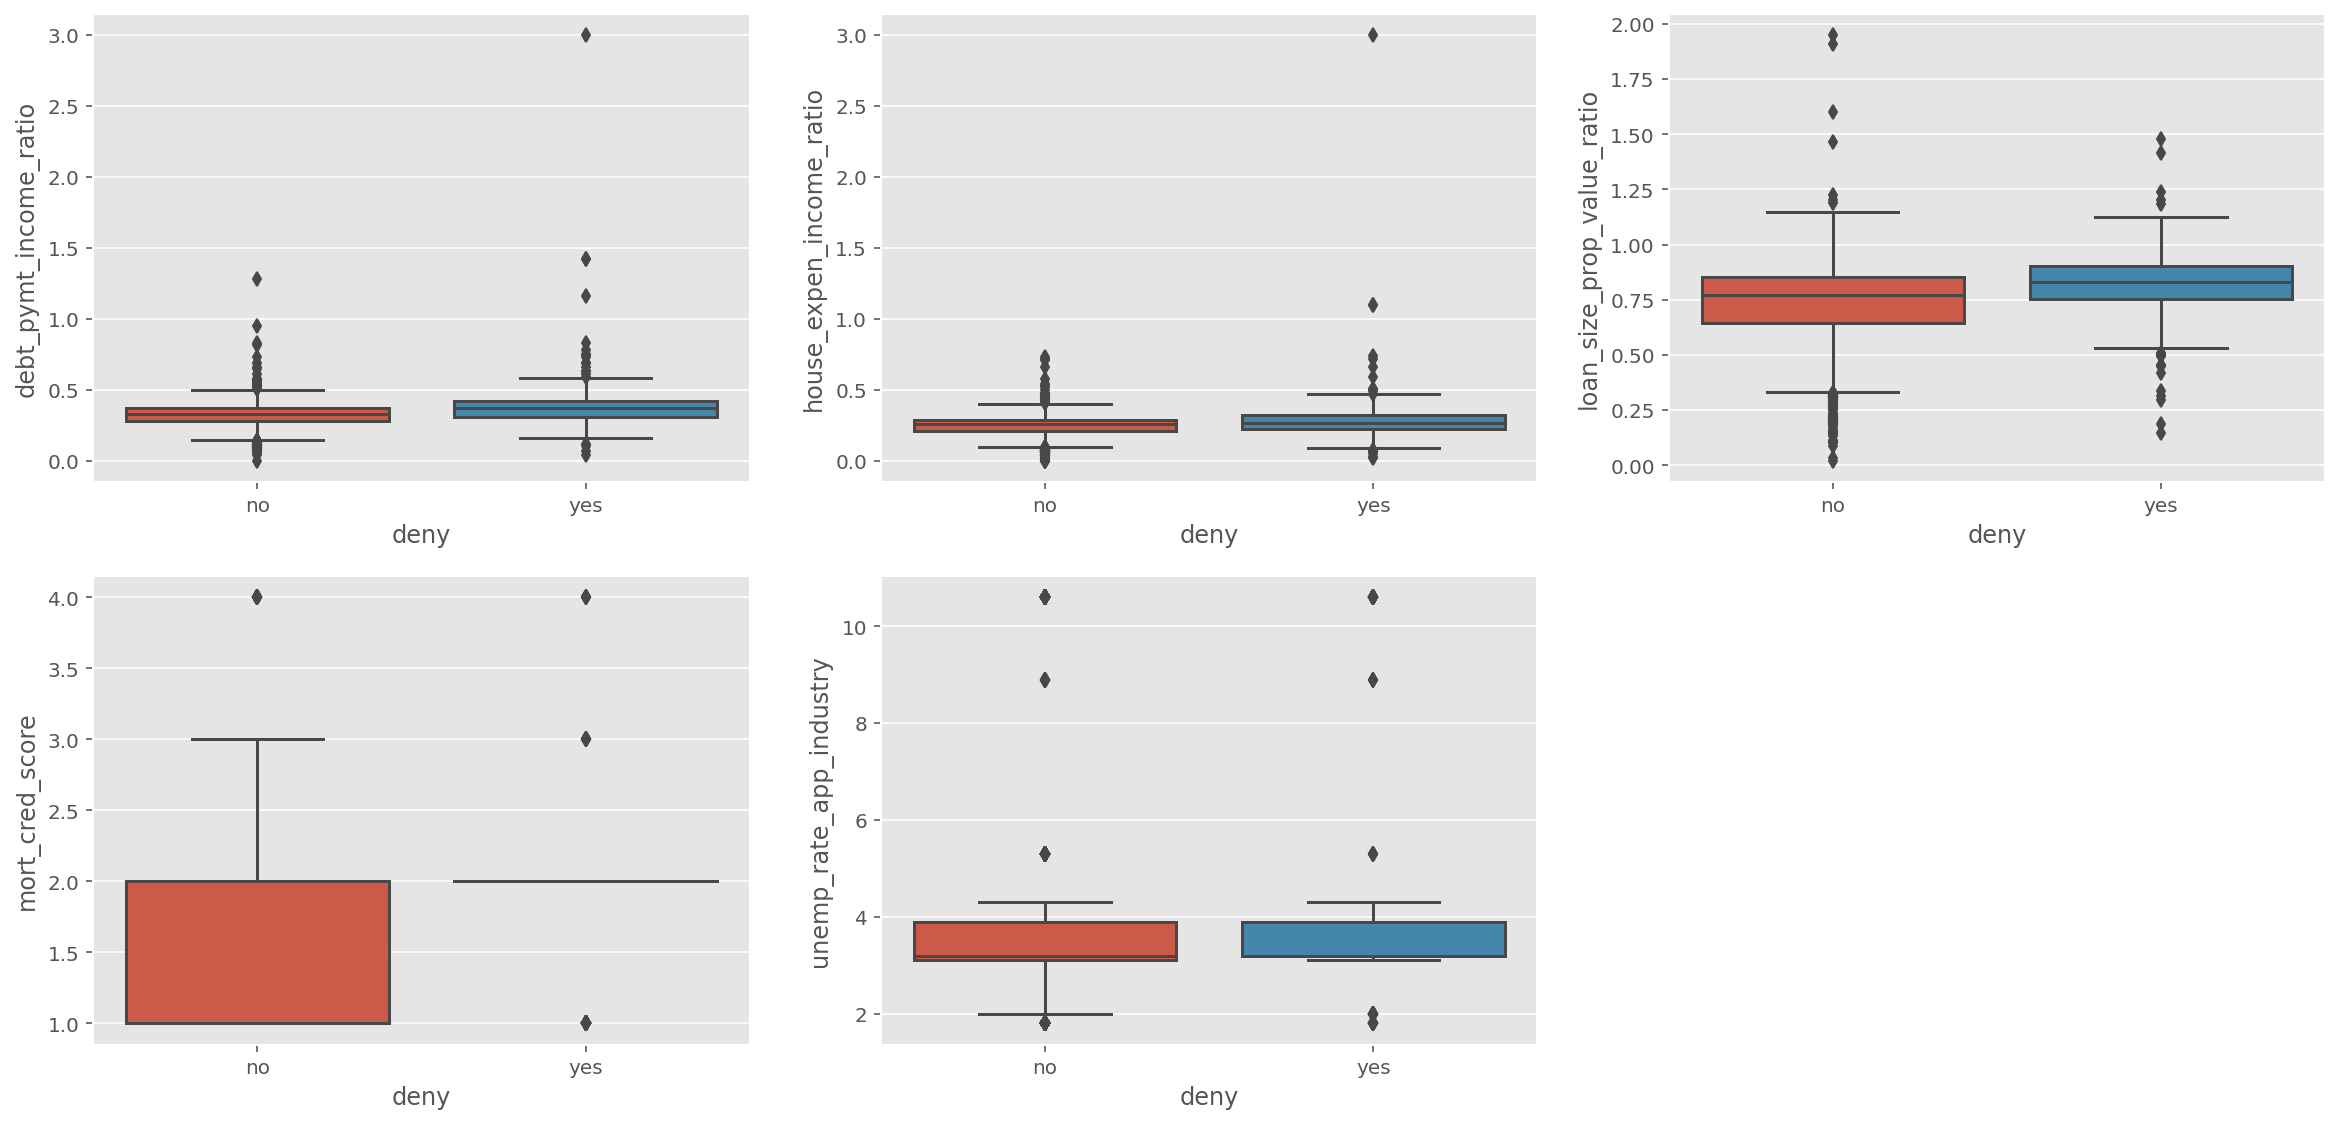

In [10]:
#define a figure to which we will add boxplots of each attribute.
plt.figure(figsize=(20,25))

#use an index to identify the spot of the subplot
j=1
columns=df[numeric].columns.tolist()
for k in columns:   #for each numeric column in the dataframe
    plt.subplot(5,3,j) 
    sns.boxplot(x="deny", y=k,data=df)
    j=j+1 #add 1 to go to the next subplot space

#show results
plt.show();

From the boxplots we can see __'loan_size_prop_value_ratio'__ to be a potential good predictor as the boxplot is slightly higher for the main IQR for applications that get denied. Below we do some analysis on the potential outliers for this feature.

In [11]:
#looking at the selected feature stats
df.loan_size_prop_value_ratio.describe()

count    2381.000000
mean        0.737760
std         0.178715
min         0.020000
25%         0.652850
50%         0.779412
75%         0.868421
max         1.950000
Name: loan_size_prop_value_ratio, dtype: float64

In [12]:
#getting values above 4 std from the mean
df.loan_size_prop_value_ratio.mean() + (4 * df.loan_size_prop_value_ratio.std())

1.4526204854828104

__Potential outliers:__ <br>
- loan_size_prop_value_ratio: we believe that keeping all values on the deny = 'yes' category would be safe for our modeling purposes, and considering we have values up to 1.5 on this outcome, the best threshold to choose for the purposes of removing outliers is that of 4 standard deviations away from the mean.

Below we create a list that will have our selected features as predictors. We include the first one, 'loan_size_prop_value_ratio'.

In [13]:
#creating a list for potential predictors
predictors = []
predictors.append('loan_size_prop_value_ratio')

### EDA on Categorical features

Below we plot our response variable vs each of the categorical features

Text(0, 0.5, 'Frequency of Mortgages')

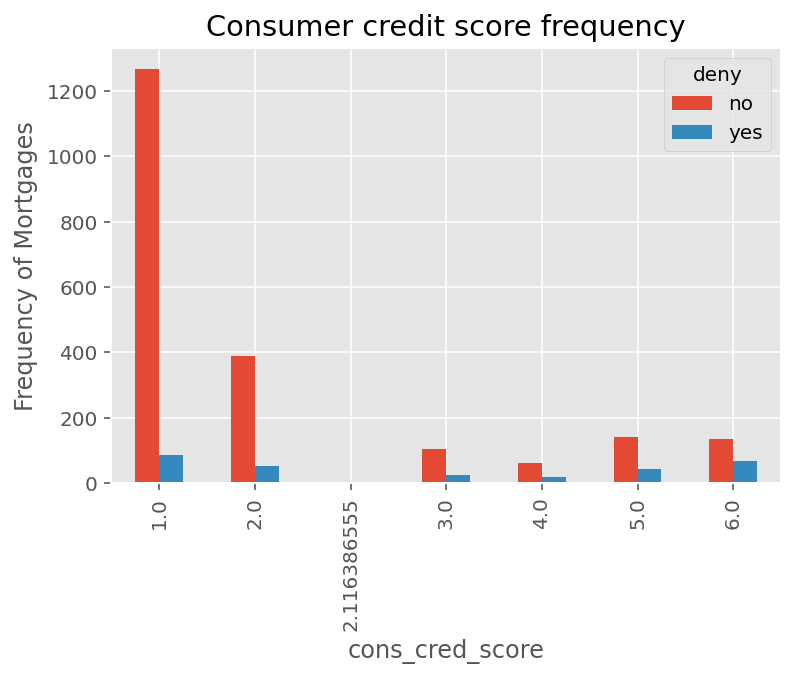

In [14]:
#consumer credit score
pd.crosstab(df.cons_cred_score,df.deny).plot(kind='bar');
plt.title('Consumer credit score frequency')
plt.xlabel('cons_cred_score')
plt.ylabel('Frequency of Mortgages')

The 'consumer credit score' status seem a strong predictor for the outcome variable. Hence we add it in our list.
According to the data dictionary the lower the score the better, and in this case 1 and 2 show more chances of getting the mortgage approved.

In [15]:
predictors.append('cons_cred_score')

Text(0, 0.5, 'Frequency of Mortgages')

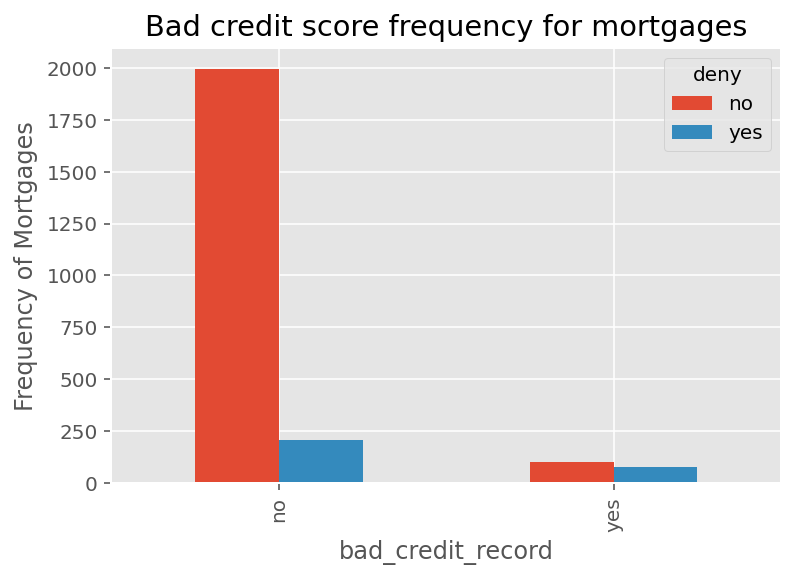

In [16]:
#public bad credit record 
pd.crosstab(df.bad_credit_record,df.deny).plot(kind = 'bar');
plt.title('Bad credit score frequency for mortgages')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The 'bad_credit_record' status seem a strong predictor for the outcome variable. Hence we add it in our list. We see that if the applicant does not have a bad credit record is very unlikely that it will be rejected.

In [17]:
predictors.append('bad_credit_record')

Text(0, 0.5, 'Frequency of Mortgages')

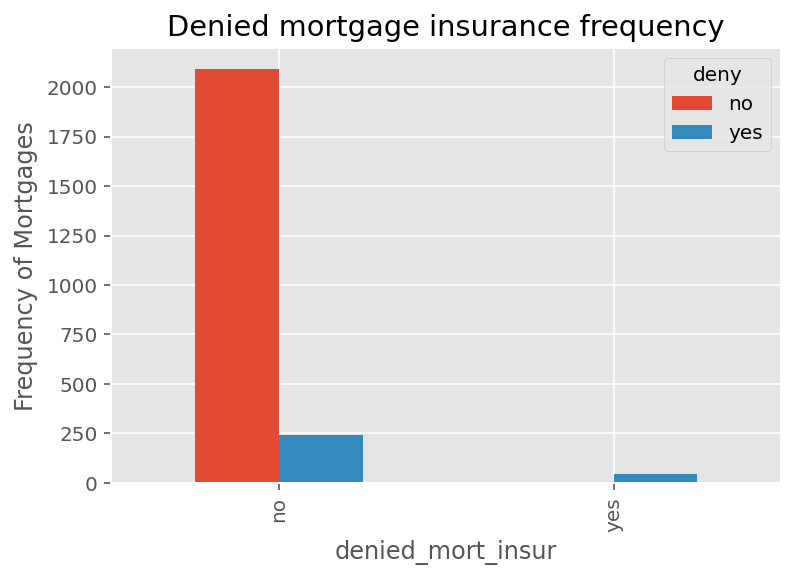

In [18]:
# denied mortgage insurance
pd.crosstab(df.denied_mort_insur,df.deny).plot(kind='bar');
plt.title('Denied mortgage insurance frequency')
plt.xlabel('denied_mort_insur')
plt.ylabel('Frequency of Mortgages')

The frequency of mortgages depends a great deal on the public credit record. Thus, the public bad credit record can be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

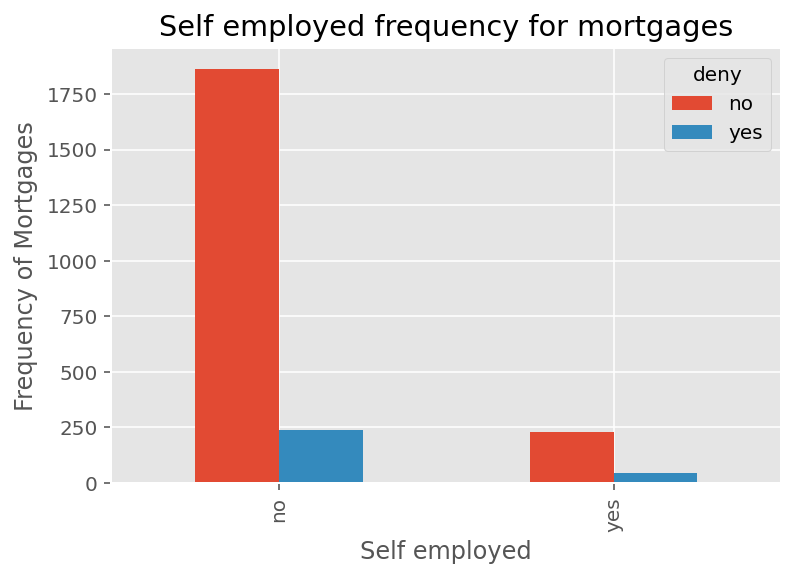

In [19]:
predictors.append('denied_mort_insur')

#self employed 
pd.crosstab(df.self_emp,df.deny).plot(kind='bar');
plt.title('Self employed frequency for mortgages')
plt.xlabel('Self employed')
plt.ylabel('Frequency of Mortgages')

The self employed status seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

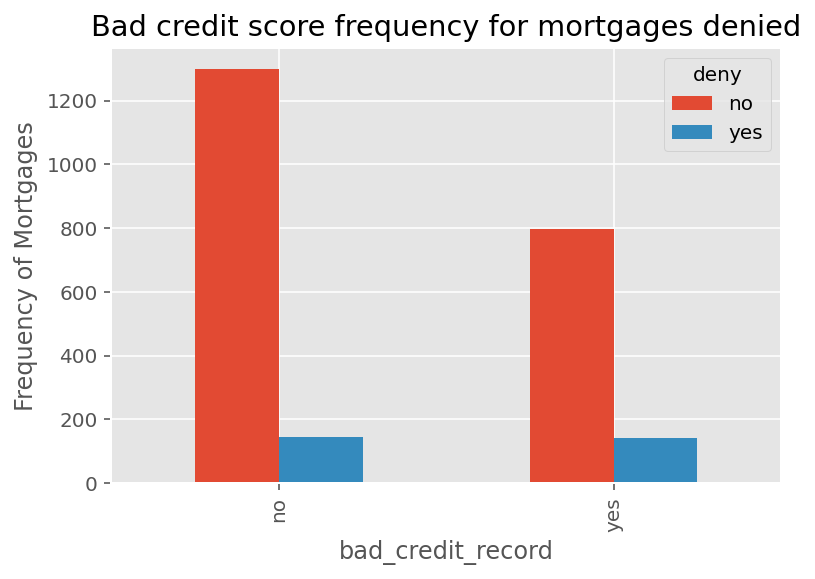

In [20]:
predictors.append('self_emp')

#is the applicant single 
pd.crosstab(df.single,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The single status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

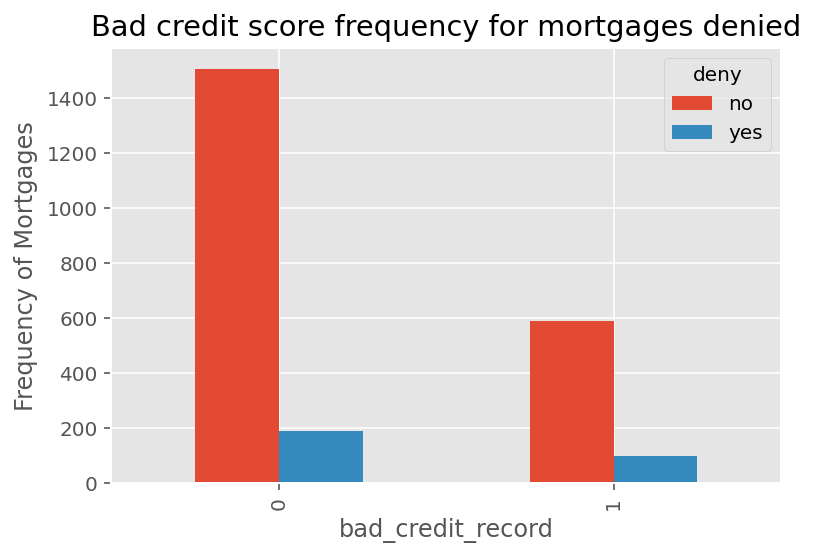

In [21]:
#is unit a condominium 
pd.crosstab(df.unit_condo,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The unit being a condo can potentially be a good predictor, but it is not so clear.

Text(0, 0.5, 'Frequency of Mortgages')

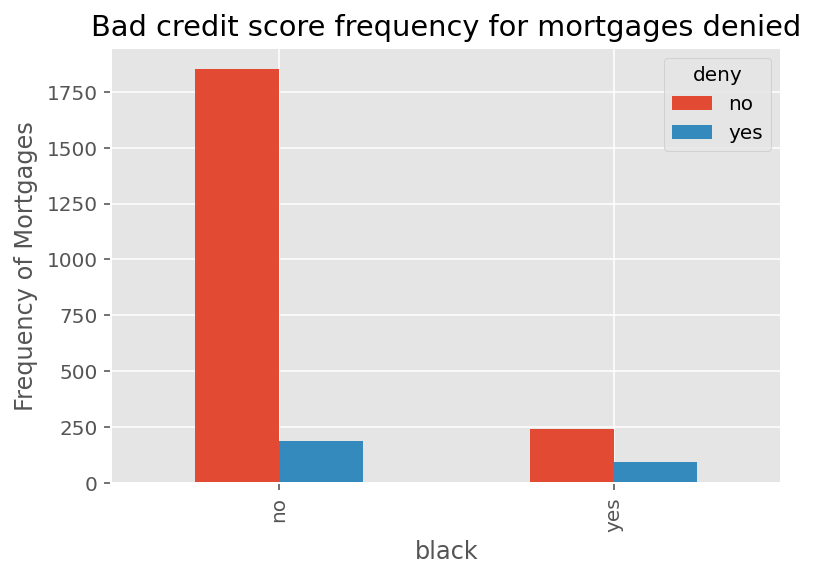

In [22]:
#is the applicant black 
pd.crosstab(df.black,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('black')
plt.ylabel('Frequency of Mortgages')

The black status does not seem a strong predictor for the outcome variable.

In [23]:
predictors

['loan_size_prop_value_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

# Data Preparation

Describe + show the steps you have taken to address the data integrity + usability issues you identified in your EDA, including any feature engineering techniques you have applied to the data set. This section should include any Python code used for Data Preparation.

## Deleting null values

In [24]:
#exclude the only record with null values
df = df.dropna()
df.shape

(2380, 13)

## Excluding Outliers

In [25]:
#deleting some outliers
df = df[df.loan_size_prop_value_ratio <= 1.5]
df.shape

(2377, 13)

## Over-sampling using SMOTE

Considering the imbalance class in the response we need to find a way to make the 2 outcomes somewhat even. With our training data created, I’ll up-sample the no-deny using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE: 

- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [26]:
#first we replace 'no' with zero and 'yes' with 1
df.bad_credit_record.replace(["no", "yes"], [0, 1], inplace = True)
df.denied_mort_insur.replace(["no", "yes"], [0, 1], inplace = True)
df.self_emp.replace(["no", "yes"], [0, 1], inplace = True)
df.single.replace(["no", "yes"], [0, 1], inplace = True)
df.black.replace(["no", "yes"], [0, 1], inplace = True)
df.deny.replace(["no", "yes"], [0, 1], inplace = True)

# Splitting into predictors and response.
X = df.loc[:, df.columns != 'deny']
y = df.loc[:, 'deny']

# Balancing
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Columns
columns = X_train.columns

# Split and balance
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

# Changing 
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y = pd.DataFrame(data=os_data_y,columns=['deny'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['deny']==0]))
print("Number of subscription",len(os_data_y[os_data_y['deny']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['deny']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['deny']==1])/len(os_data_X))

length of oversampled data is  2932
Number of no subscription in oversampled data 1466
Number of subscription 1466
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [27]:
# Making a copy of the last original data frame.
df2 = os_data_X.copy()
df2['deny'] = os_data_y

## Feature Selection.

Despite having preformed EDA we have decided to apply some feature selection methods to explore other features and experiment on whether or not they were better than the choices we made based off our EDA.

### Univariate.

In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features. This is according to the sklearn documentation.

http://scikitlearn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

# find best scored 5 features
select_feature = SelectKBest(chi2, k=4).fit(df2[categorical],df2['deny'])

# Created a dictionary.
dic = {}
for score, name in zip(select_feature.scores_,df2[categorical].columns):
    dic[name] = score
    
# Sorting the dictionary.
dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
dic

{'cons_cred_score': 486.6991729324232,
 'denied_mort_insur': 140.0,
 'bad_credit_record': 123.96755162241888,
 'black': 54.03137254901961,
 'self_emp': 13.533834586466165,
 'unit_condo': 1.0499375780274656,
 'single': 0.195822454308094}

We have the chosen the top 4 predictive categorical features, because they have the highest scores and anything below that was not significant enough to include. Because of this we only included 4 of the categorical variables in addition to a numerical variable that we have deemed to be potentially predictive relying on the information we obtained from the EDA prior to this section.

In [29]:
predictors

['loan_size_prop_value_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

In [30]:
predictors2 = ['cons_cred_score', 'denied_mort_insur', 'bad_credit_record', 'black', 'loan_size_prop_value_ratio'] #'black is the only difference'

### 2 sets of predictors

In [31]:
predictors # Obtained from EDA

['loan_size_prop_value_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

In [32]:
predictors2 # Obtained from Univariate feature selection with selectKbest and ChiSquared.

['cons_cred_score',
 'denied_mort_insur',
 'bad_credit_record',
 'black',
 'loan_size_prop_value_ratio']

# Prepped Data Review

Considering we have changes on the entire dataset with the over-sampling, we will rerun the EDA on all of them, focusing on the ones we selected as promising predictors.

### Numerical Features

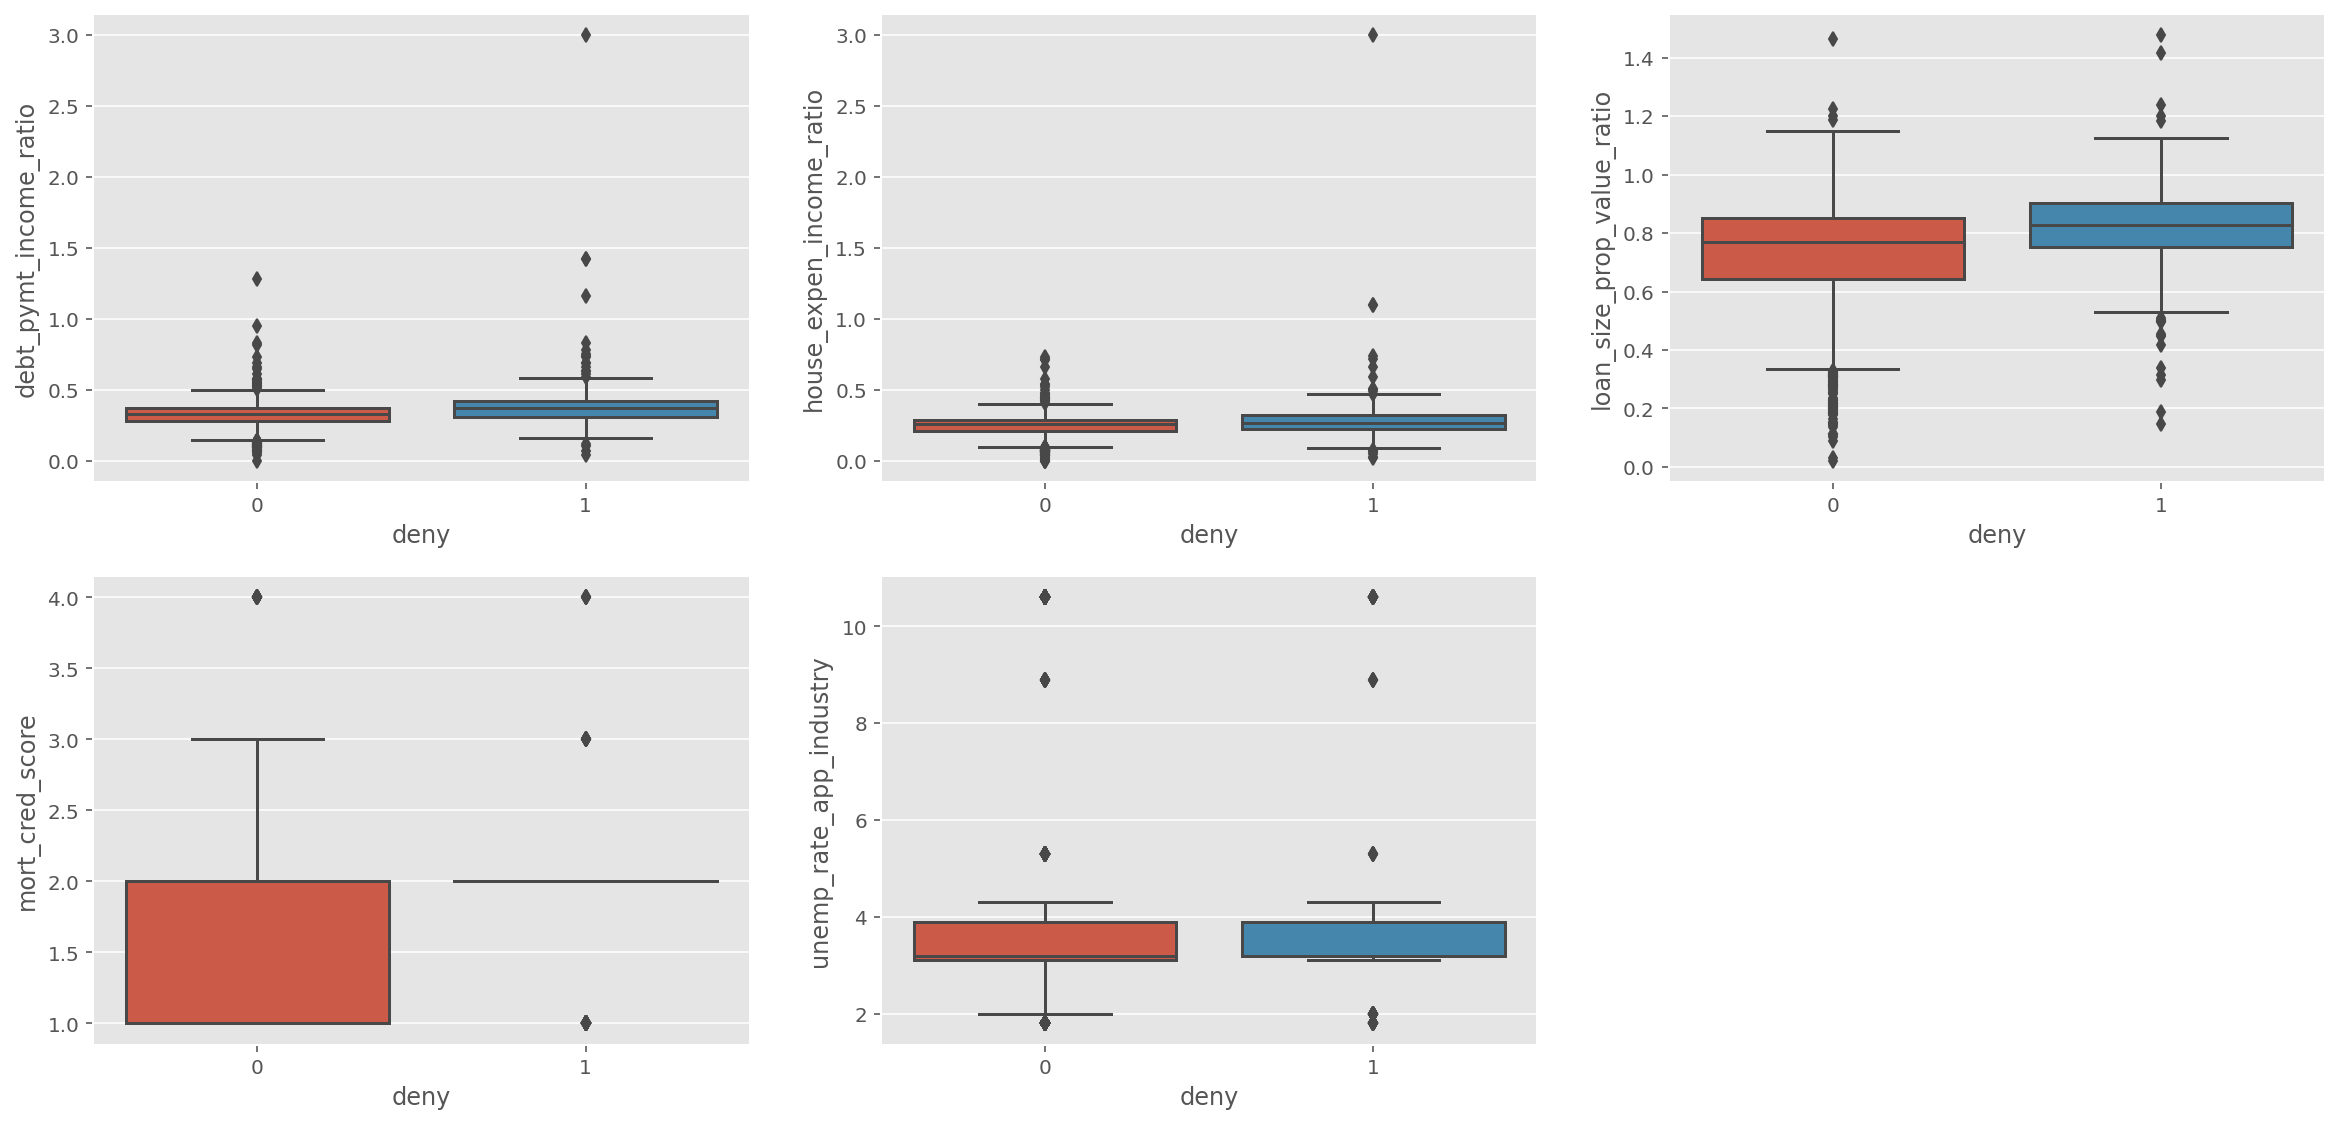

In [33]:
#define a figure to which we will add boxplots of each attribute.
plt.figure(figsize=(20,25))

#use an index to identify the spot of the subplot
j = 1

# Columns
columns = df2[numeric].columns.tolist()

for k in columns:   #for each numeric column in the dataframe
    plt.subplot(5,3,j) 
    sns.boxplot(x = "deny", y = k,data = df)
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.show();

We can see that __loan_size_prop_value_ratio__ is still a promising predictor.

In [34]:
#rounding decimal numbers for consumer credit score
df2 = df2.round({'cons_cred_score': 0})

Text(0, 0.5, 'Frequency of Mortgages')

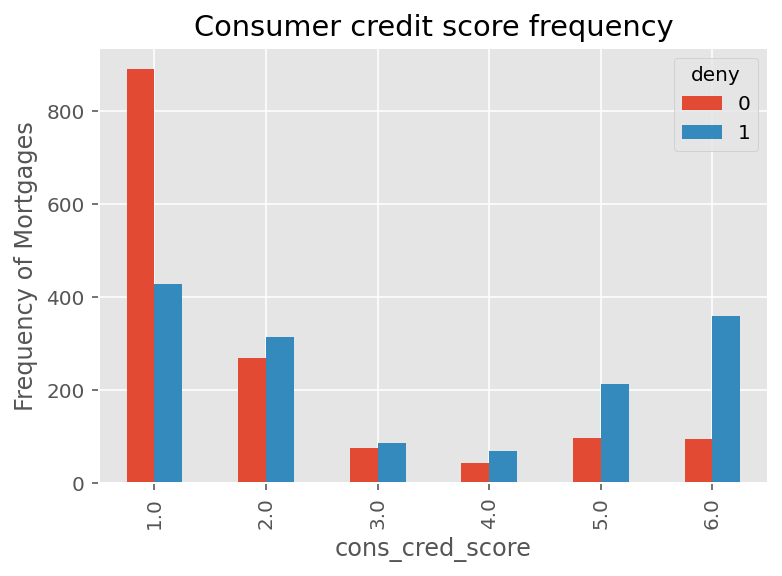

In [35]:
#consumer credit score
pd.crosstab(df2.cons_cred_score,df2.deny).plot(kind='bar');
plt.title('Consumer credit score frequency')
plt.xlabel('cons_cred_score')
plt.ylabel('Frequency of Mortgages')

We can see that __Consumer credit score__ is still a promising predictor.

Text(0, 0.5, 'Frequency of Mortgages')

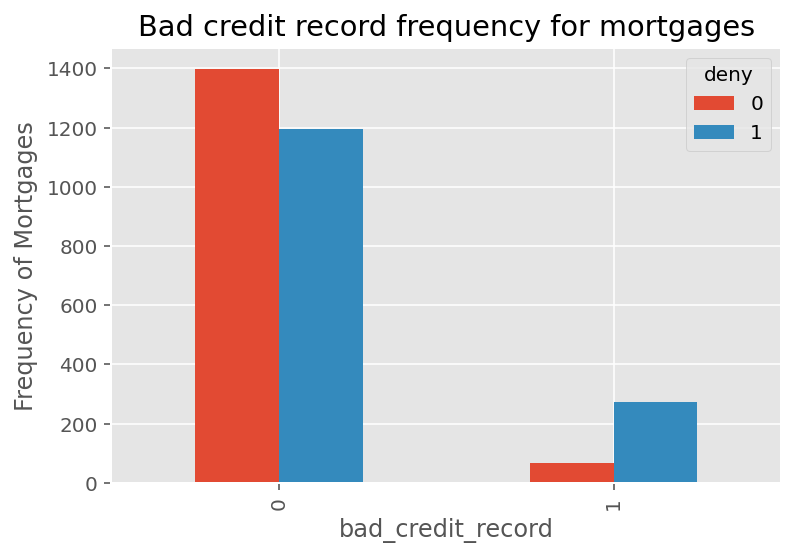

In [36]:
#public bad credit record 
pd.crosstab(df2.bad_credit_record,df2.deny).plot(kind = 'bar');
plt.title('Bad credit record frequency for mortgages')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

We can see that __Bad credit records__ is still a promising predictor.

Text(0, 0.5, 'Frequency of Mortgages')

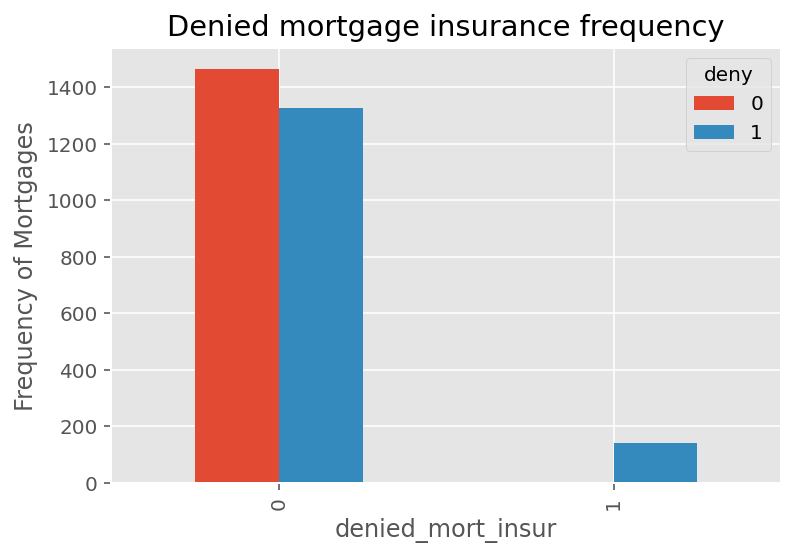

In [37]:
# denied mortgage insurance
pd.crosstab(df2.denied_mort_insur,df2.deny).plot(kind='bar');
plt.title('Denied mortgage insurance frequency')
plt.xlabel('denied_mort_insur')
plt.ylabel('Frequency of Mortgages')

We can see that __Denied mortgage insurance__ is still a strong predictor.

Text(0, 0.5, 'Frequency of Mortgages')

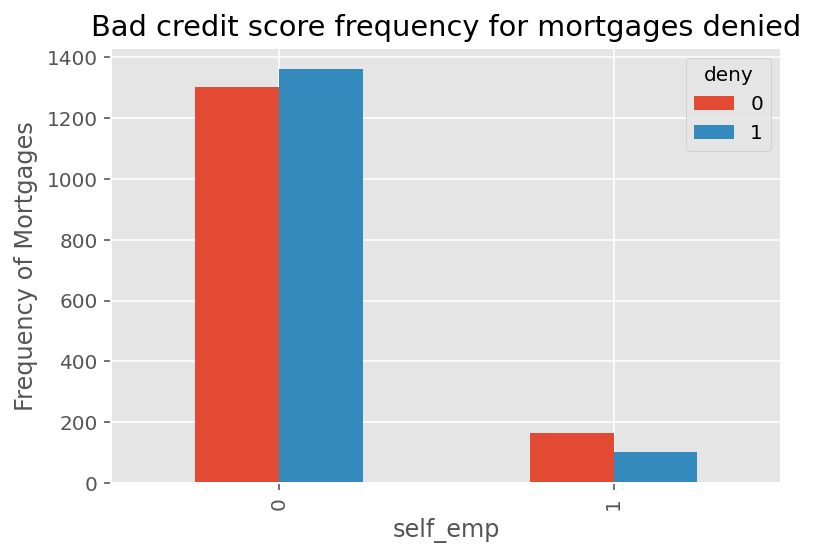

In [38]:
#is the applicant black 
pd.crosstab(df2.self_emp,df2.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('self_emp')
plt.ylabel('Frequency of Mortgages')

We can see that __self employed__ is still a good predictor.

Text(0, 0.5, 'Frequency of Mortgages')

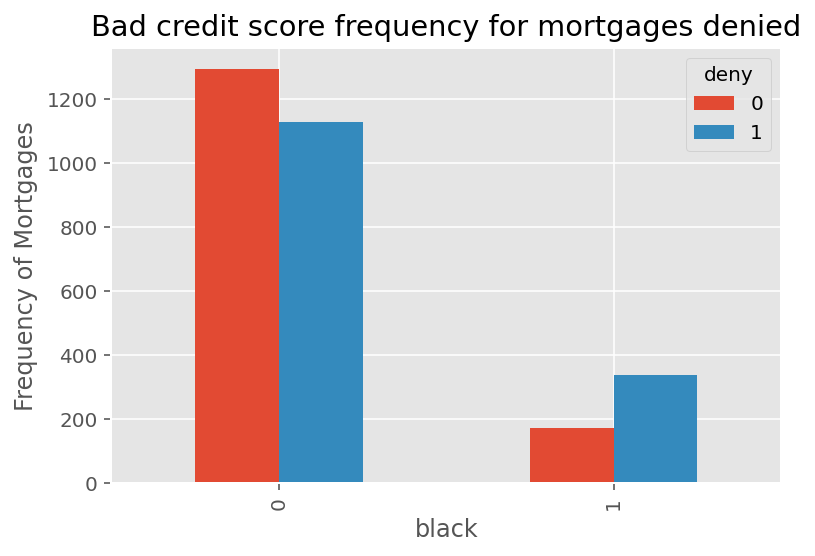

In [39]:
#is the applicant black 
pd.crosstab(df2.black,df2.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('black')
plt.ylabel('Frequency of Mortgages')

We can see that __black__ now appears to be a good predictor.

In [40]:
#print value counts
print(df2.deny.value_counts())

1    1466
0    1466
Name: deny, dtype: int64


We can see that the response is evenly distributed.

# Regression Modeling

In this section we will make use of the feature selection and EDA work to create 3 logistic regression models. One of them will be applied to the original dataframe (with imbalance response) and using the first set of predictors. Then 2 models using the new dataframe after applying over-sampling, with one model using the first set of features and the last one with the second set of features. <br>
We will also interpret the coefficients of each model as part of our analysis.

#### Model 1

In [41]:
#model 1 with EDA features
X = df[predictors]
y = df['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Fitting Logistic Regression to the Training set with the first set of predictors.
classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

#examine the model coefficients for the explanatory variables
print(predictors)
print(classifier1.coef_)

# Cross validation.
accuracy_list = []
recall_list = []
auc_list = []
f1_list = []
precision_list = []

accuracy = cross_val_score(classifier1, X_train, y_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(classifier1, X_train, y_train, scoring = "recall", cv = 10)
auc = cross_val_score(classifier1, X_train, y_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(classifier1, X_train, y_train, scoring = "f1", cv = 10)
precision = cross_val_score(classifier1, X_train, y_train, scoring = "precision", cv = 10)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

['loan_size_prop_value_ratio', 'cons_cred_score', 'bad_credit_record', 'denied_mort_insur', 'self_emp']
[[1.98729394 0.3071551  1.32845553 3.82998027 0.63987924]]


In [42]:
from sklearn.metrics import confusion_matrix
y_pred1 = classifier1.predict(X_test)
y_test1 = y_test


From the above we see that:

- __Ratio of size of loan to assessed value of property__: An increase in the Ratio of size of loan to assessed value of property is associated with an __increased__ likelihood of denial, i.e., suggesting that more money the applicant requests in comparison to the property value, the more likely the application will be denied.

- __Consumer credit score__: An increase in the consumer credit score is associated with an __increased__ likelihood of denial, i.e., suggesting that the higher the score the more likely the application will be denied.

- __Public bad credit record__: Having a bad credit score increased the likelihood of getting your application denied.

- __Denied mortgage insurance__: Having a mortgage insurance denied increased the likelihood of getting an application denied.

- __Self employed__: Being self employed increased the likelihood of getting an application denied.

#### Model 2

In [43]:
#model 2 SMOTE and with EDA features
X = df2[predictors]
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_test2 = X_test.copy() # Copy for the final testing unit.
y_test2 = y_test.copy() # copy for ftunit.
#Fitting Logistic Regression to the Training set with the first set of predictors.
classifier2 = LogisticRegression()
classifier2.fit(X_train, y_train)

#examine the model coefficients for the explanatory variables
print(predictors)
print(classifier2.coef_)

# Cross validation.
accuracy = cross_val_score(classifier2, X_train, y_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(classifier2, X_train, y_train, scoring = "recall", cv = 10)
auc = cross_val_score(classifier2, X_train, y_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(classifier1, X_train, y_train, scoring = "f1", cv = 10)
precision = cross_val_score(classifier1, X_train, y_train, scoring = "precision", cv = 10)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

['loan_size_prop_value_ratio', 'cons_cred_score', 'bad_credit_record', 'denied_mort_insur', 'self_emp']
[[ 2.47611336  0.37318216  0.51370085  3.64299572 -0.28791459]]


In [44]:
from sklearn.metrics import confusion_matrix 
y_pred2 = classifier2.predict(X_test)
y_test2 = y_test

From the above we see that:

- __Ratio of size of loan to assessed value of property__: An increase in the Ratio of size of loan to assessed value of property is associated with an __increased__ likelihood of denial, i.e., suggesting that more money the applicant requests in comparison to the property value, the more likely the application will be denied.

- __Consumer credit score__: An increase in the consumer credit score is associated with an __increased__ likelihood of denial, i.e., suggesting that the higher the score the more likely the application will be denied.

- __Public bad credit record__: Having a bad credit score increased the likelihood of getting your application denied.

- __Denied mortgage insurance__: Having a mortgage insurance denied increased the likelihood of getting an application denied.

- __Self employed__: Being self employed __decreased__ the likelihood of getting an application denied.

#### Model 3

In [45]:
#model 3 SMOTE and with 2nd set of features
X = df2[predictors2]
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Fitting Logistic Regression to the Training set with the first set of predictors.
classifier3 = LogisticRegression()
classifier3.fit(X_train, y_train)

#examine the model coefficients for the explanatory variables
print(predictors2)
print(classifier3.coef_)

# Cross validation.
accuracy = cross_val_score(classifier3, X_train, y_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(classifier3, X_train, y_train, scoring = "recall", cv = 10)
auc = cross_val_score(classifier3, X_train, y_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(classifier1, X_train, y_train, scoring = "f1", cv = 10)
precision = cross_val_score(classifier1, X_train, y_train, scoring = "precision", cv = 10)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

['cons_cred_score', 'denied_mort_insur', 'bad_credit_record', 'black', 'loan_size_prop_value_ratio']
[[0.36373975 3.68002008 0.48399256 0.45574152 2.38768614]]


In [46]:
from sklearn.metrics import confusion_matrix
y_pred3 = classifier3.predict(X_test)
y_test3 = y_test


From the above we see that:

- __Consumer credit score__: An increase in the consumer credit score is associated with an __increased__ likelihood of denial, i.e., suggesting that the higher the score the more likely the application will be denied.

- __Denied mortgage insurance__: Having a mortgage insurance denied increased the likelihood of getting an application denied.

- __Public bad credit record__: Having a bad credit score increased the likelihood of getting your application denied.


- __Is the applicant black__: If the applicant is african-american the likelihood of getting your application denied increases.

- __Ratio of size of loan to assessed value of property__: An increase in the Ratio of size of loan to assessed value of property is associated with an __increased__ likelihood of denial, i.e., suggesting that more money the applicant requests in comparison to the property value, the more likely the application will be denied.

#### Analyzing all model coefficients

In [47]:
explanatory = predictors2.copy()
explanatory.append('self_emp')
coef_matrix = pd.DataFrame(explanatory, columns=sorted(['explanatory']))
coef_matrix['Model1_coeff'] = [0.3071551, 3.82998027, 1.32845553, np.nan, 1.98729394, 0.63987924]
coef_matrix['Model2_coeff'] = [0.37421087, 3.64460078, 0.51309551, np.nan,2.47311665, -0.28847866]
coef_matrix['Model3_coeff'] = [0.36485386, 3.68202758, 0.48308205, 0.45759193, 2.38513761, np.nan]
coef_matrix

,explanatory,Model1_coeff,Model2_coeff,Model3_coeff
0,cons_cred_score,0.307155,0.374211,0.364854
1,denied_mort_insur,3.829980,3.644601,3.682028
2,bad_credit_record,1.328456,0.513096,0.483082
3,black,NaN,NaN,0.457592
4,loan_size_prop_value_ratio,1.987294,2.473117,2.385138
5,self_emp,0.639879,-0.288479,NaN


- __Loan_size_value_prop__<br/> To a greater extent, Loan_size_value_prop is indicative of an increase in likelihood in getting your application declined in model 2 than in models 1 and 3.
- __cons_cred_score__<br/> To a greater extent, cons_cred_score is indicative of an increase in likelihood in getting your application declined in model 1 than in models 2 and 3.
- __bad_credit_record__<br/> To a greater extent, bad_credit_record is indicative of an increase in likelihood in getting your application declined in model 1 than in models 2 and 3.
- __denied_mort_insurance__<br/> To a greater extent, denied_mort_insurance is indicative of an increase in likelihood in getting your application declined in model 1 than in models 2 and 3.
- __self_emp__<br/> To a greater extent, self_emp is indicative of an increase in likelihood in getting your application declined in model 1 whereas in model 2 to a lesser extent slef_emp is indicative of a decrease in likelihood in getting your application declined.
- __black__<br/> To a lesser extent, an applicant being black is indicative of a decrease in likelihood in getting your application declined in model 3.


These findings make intuitive sense overall:<br/>
- __Loan_size_value_prop__ The larger the ratio of the property value to the amount of money requested should increase the likelihood of getting an application denied.<br/>
- __cons_cred_score__ The "higher" the value of the credit score is (in our case that means the lower someone's credit score is) the higher the likelihood that apprlication will be denied.<br/>
- __bad_credit_record__ The worse a person's credit record is the more likely an applications will be denied.<br/>
- __denied_mort_insurance__ If a person was denied mortgage insurance then it makes sense that the likelihood that the application will be deined is much higher.<br/>
- __self_emp__ While it makes intutive sense that being self-employed increases your chances of getting your application rejected this Model seems to think otherwise as it seems to do quite the opposite, however it is noteworthy that the coeffecient is low.<br/>
- __black__ If an applicant is black having an  increased liklihood of being denied a mortgage also falls in line with banking practices of not making loans to low income areas. These ares were predominantly african american and would explain the effect that we see here.  

# Model Selection

To make a selection of the most predictive model, we collected through cross-validation different performance metrics and we will show them together in a dataframe for better understanding and to compare them easily to pick the best model. In the following section we will explain it from a metrics perspective and we will also review the class imbalance problem.

In [48]:
print("\t \t The Model Metric Matrix")
# Cross validation.
metrics_summary = pd.DataFrame()
metrics_summary['Model #'] = ['model 1', 'model 2', 'model 3']
metrics_summary['Recall'] = recall_list
metrics_summary['Accuracy'] = accuracy_list
metrics_summary['Precision'] = precision_list
metrics_summary['AUC'] = auc_list
metrics_summary['F1_score'] = f1_list
metrics_summary

	 	 The Model Metric Matrix


,Model #,Recall,Accuracy,Precision,AUC,F1_score
0,model 1,0.252767,0.902695,0.800000,0.780265,0.373542
1,model 2,0.586661,0.685670,0.739697,0.758284,0.653199
2,model 3,0.580772,0.680118,0.732963,0.762692,0.647183



- Model 1
    - Model 1 uses the original dataset which appears to be significantly imbalanced in terms of the response variable as the amount applicants who were not denied were a great deal more than those who were denied. While model 1 provided an incredible accuracy score ~90%, we were hesitant to choose model 1 because of how unbalanced it was, the effect of this imbalance was clearly visible when we look at the recall score pertaining to model 1 which stands at ~25% which we believe to be incredibly low and would not be suitable to use.
    - From the confusion matrix, for minority class, model 1 is only able to predict 17 correct out of 45 samples. For majority class, model got only 5 predictions wrong. Model is not doing a good job in predicting minority class. Nonetheless, with these default weights performance values, we got benchmark to measure subsequent model modifications.
 
- Model 2 & Model 3
    
    - In model 2 & 3 we decided to circumvent the issue of the class imbalance through preprocessing the data by means of over-sampling which is a way that is used to combat class imbalance. The specific method we used was that of SMOTE (Synthetic Minority Oversampling Technique) which is a very popular oversampling method that was proposed to improve random oversampling. That way we insured the fair distribution of denied applicants and accepted applicants.[2]

    - The scores in Model 2 and Model 3 are extremely similar and that is due to the fact that the predictors are almost the same with exception of self_employed in Model 2 as it was replaced with black in Model 3. All the scores for Model 2 are slightly higher than that of Model 3 except for the AUC, but the score that swayed our decision the most in favor of Model 2 was that of the F1.
    
In short we choose to go with Model 2 despite it having low accuracy in comparison one in favor of it having a better F1 score. 
Below we include the confusion matrixes that help us understand how each of these models performed on the testing set.


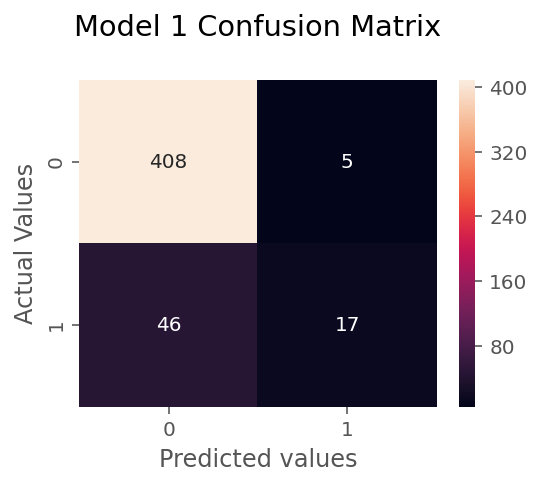

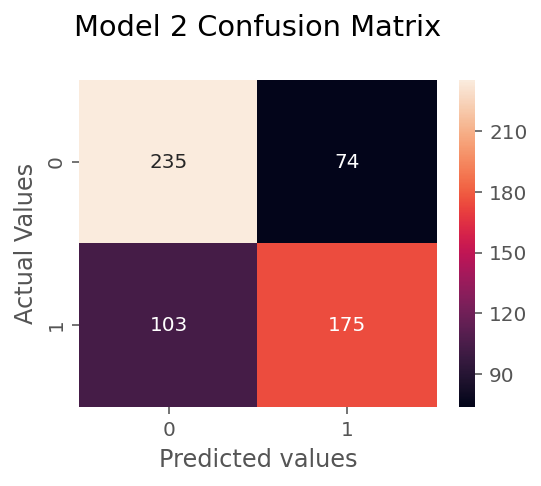

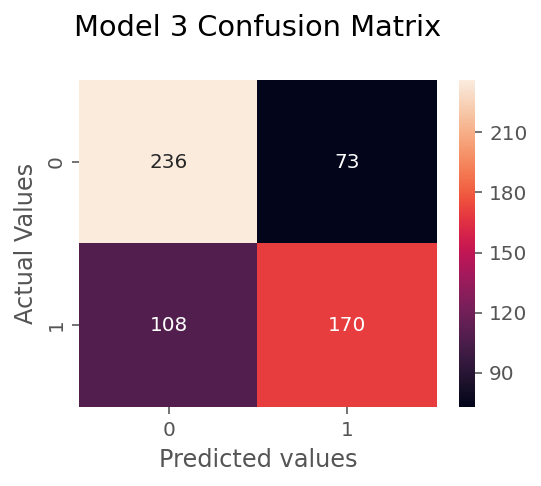

In [49]:
######  Confusion Matrix For Model 1   #####
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test1, y_pred1)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 1 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

##### Confusion Matrix for Model 2 ####
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 2 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

##### Confusion Matrix for Model 3 ####
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test3, y_pred3)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 3 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

Now we will apply the selected model to the training set and compare the outcomes of the actual values and the predicted ones.

In [50]:
classifier2.predict(X_test2[predictors])

print("\n For the test set\n")
y_pred = classifier2.predict(X_test2[predictors])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier2.score(X_test2[predictors], y_test2)))


 For the test set

Accuracy of logistic regression classifier on test set: 0.70


In [51]:
# generate class probabilities
probs = classifier2.predict_proba(X_test2)
print(probs)

[[0.39963026 0.60036974]
 [0.53761721 0.46238279]
 [0.69442174 0.30557826]
 ...
 [0.26873087 0.73126913]
 [0.5908563  0.4091437 ]
 [0.77415979 0.22584021]]


In [52]:
# performance
print(f'Accuracy Score: {metrics.accuracy_score(y_test2,y_pred)}')
print(f'Area Under Curve: {metrics.roc_auc_score(y_test2, probs[:, 1])}')
print(f'Recall score: {metrics.recall_score(y_test2,y_pred)}')

Accuracy Score: 0.6984667802385008
Area Under Curve: 0.7565074154268817
Recall score: 0.6294964028776978


If we consider that we are working with a perfect balanced dataset, where the null error rate is 50% the model we've generated has an accuracy score of 70%. As such, our model appears to be useful.

In [53]:
y_pred = pd.DataFrame(y_pred, columns = ['deny'])
y_test = pd.DataFrame(y_test, columns = ['deny'])

Text(0.5, 1.0, 'Deny predicted in testing set')

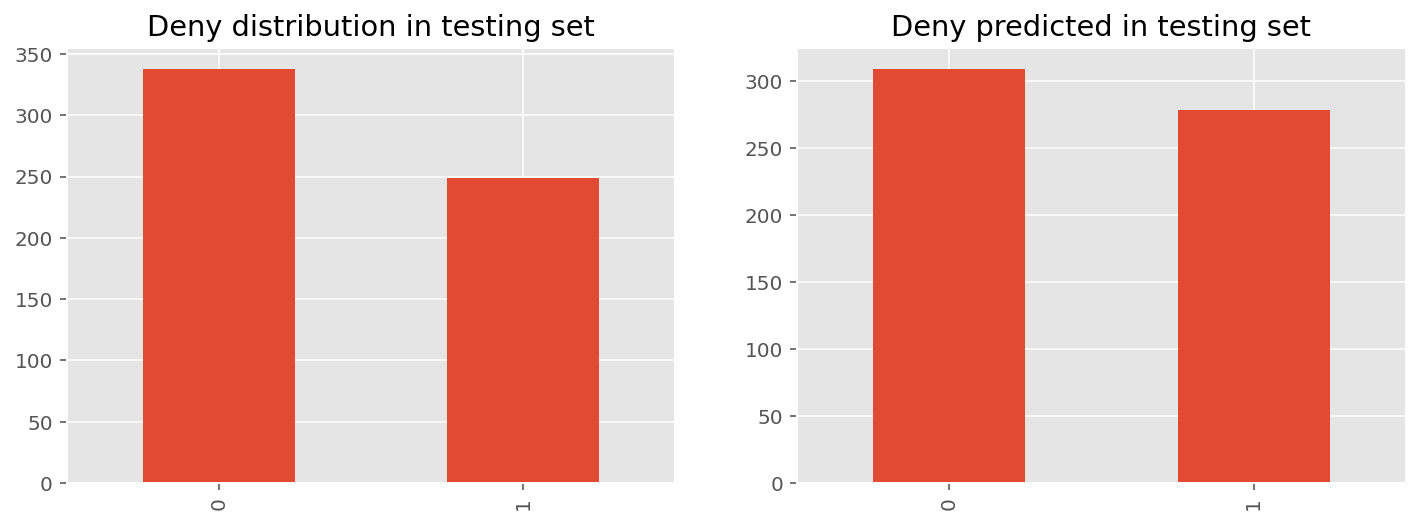

In [54]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
y_pred['deny'].value_counts().plot(kind='bar');
plt.title('Deny distribution in testing set')
plt.subplot(1,2,2)
y_test['deny'].value_counts().plot(kind='bar');
plt.title('Deny predicted in testing set')

We see that the selected model is getting values that are distributed similarly, however the model seems to have a bit more applications that got denied over those that are not denied than before.

# Conclusion

- From our EDA we applied statistical methods to extract several features that had a relationship with the response variable, and we also noticed that working with imbalance data would hinder model performance, so we trained appropriate models and tested their performance and selected the highest preforming combination.  


- What gets your application rejected ?

    - It is clear from our findings in Model 2 that it is imperative for an applicant not to have their mortgage insurance denied. This is because it is a huge contributor to getting your application denied. We know this becasue the coeficiant of this predictor is large and positive. 

    - We were also able to confirm through our analysis that any increase in the Ratio of size of the loan to the assessed value of property is associated with an increased likelihood of denial. In order to get an application approved, an applicant must be concerned with the ratio size of the loan relative to the assessed value of the property.

    - Another finding from our study was that a bad credit score increases the liklihood of your application being denied. While this is not surprising, we were suprised to learn the extent - or lack thereof - of this relationship. The coeficient of this variable is of a medium weight in the context of this study.  
    
    - Public bad credit record: Having a bad credit score increased the likelihood of getting your application denied.
    
    - Being self employed decreased the likelihood of getting an application denied. 
    
- We performed our model selection based on the analysis of the performance metrics. It was apparent that we needed a model with the ability to predict not only the true positive but also the true negatives, without relying on only one of the values of the outcome.

## Refrences

[1] https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106
